Imports

In [1]:
# General

from scipy import stats
import scipy
from skimage.filters import threshold_otsu, rank
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from skimage.morphology import binary_erosion, binary_dilation, disk, square
import pandas as pd
import sys
from scipy import ndimage
from datacube import helpers
from datacube.utils import geometry

# PCA

# import sklearn
sys.path.append('/g/data/u46/users/sc0554/cult_area/LCCS/')
from xarray_pca import xarray_pca

# Image Seg

from skimage import io
from skimage.segmentation import quickshift
import sklearn.feature_extraction.image
import sklearn.cluster
from skimage.segmentation import mark_boundaries, slic, watershed
from skimage.util import img_as_float
from skimage.color import rgb2gray
from skimage.filters import sobel

In [2]:
# Open dataset
tmad = xr.open_dataset('/g/data/u46/users/sc0554/cult_area/townsville_1y_input/mad-20160101-20161231_15_-22.nc')
# tmad = xr.open_dataset('/g/data/u46/users/sc0554/cult_area/Barmah-Millewa_2y_input/mad-20150101-20161231_11_-40.nc')
# tmad = xr.open_dataset('/g/data/u46/users/sc0554/cult_area/Snowy_2y_input/mad-20150101-20161231_14_-41.nc')

# Subset here

tmad_sub = tmad.isel(x=slice(500,2000), y=slice(500, 2000))

In [4]:
tmad_pca = xarray_pca(tmad, ['sdev', 'bcdev', 'edev'])

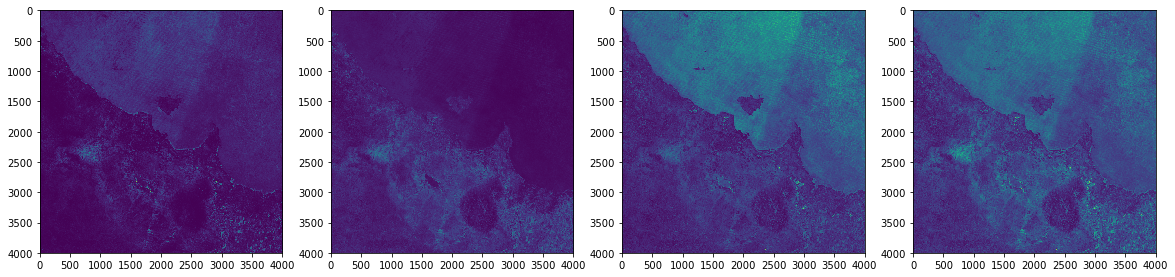

In [5]:
fig, axes = plt.subplots(1,4, figsize=(20,10))
axes[0].imshow(tmad.sdev.isel(time=0))
axes[1].imshow(tmad.edev.isel(time=0))
axes[2].imshow(tmad.bcdev.isel(time=0))
axes[3].imshow(tmad_pca)

# Image segmentation

In [7]:
# read in max ndvi data and convert to Numpy array

img_path = '/g/data/u46/users/sc0554/cult_area/townsville_1y_input/woody_15_-22.nc'
# img_path = '/g/data/u46/users/sc0554/cult_area/Barmah-Millewa_2y_input/woody_11_-40.nc'
# img_path = '/g/data/u46/users/sc0554/cult_area/Snowy_2y_input/woody_14_-41.nc'
# img = io.imread(image)
# img = xr.open_rasterio(img_path)
img = xr.open_dataset(img_path)
img_v = np.squeeze(img['veg'].values).astype(float)
img_s = img['veg'].isel(x=slice(2500, 4000), y=slice(2500, 4000))
img_sv = np.squeeze(img_s.values).astype(float)

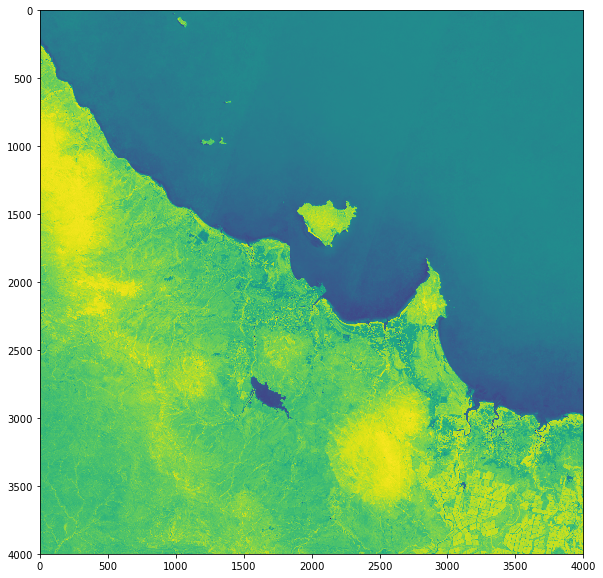

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(img.bare.values.squeeze())

In [10]:
# Segment the  max ndvi numpy array

# %%time
# Note: convert2lab=False allows the use of multiband images
seg_qs = quickshift(img_v, kernel_size=5, convert2lab=False, max_dist=500, ratio=0.5)
print("Quickshift number of segments: %d" % len(np.unique(seg_qs)))

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(mark_boundaries(img_v, seg_qs))

In [ ]:
# Calculate the median max ndvi value for each segment

seg_median = scipy.ndimage.median(input=img_v, labels=seg_qs, index=seg_qs)

In [ ]:
# Calculate the optimum threshold for max NDVI
thresh = threshold_otsu(seg_median)
thresh = 0.4
# Filter by the threshold
thresh_seg_median = seg_median < thresh

# seg_median_filt = np.where(seg_median_filt > 0.4, 1, 0)
# seg_median_filt = np.where(seg_median_filt > 0.55, 1, 0) # tville

In [ ]:
print(thresh_seg_median)
fig, ax = plt.subplots(ncols=1, figsize=(15,5))
ax.hist(seg_median.ravel(), bins=256)
ax.set_title('Histogram')
ax.axvline(thresh, color='r')

In [ ]:
# Create an empty numpy array with the same shapre as the input
img_fill = np.ones((img_v.shape))
# Assign the segment size values to each value belonging to that 
seg_size = scipy.ndimage.sum(input=img_fill, labels=segments_quickshift, index=segments_quickshift)
print(np.unique(seg_size))

In [ ]:
# Filter by segment size
thresh_seg_median_filt = np.where((seg_size > 500) & (seg_size < 5000), thresh_seg_median, 0) # previously 2000 for small size
# seg_median_filt = np.where((seg_size > 2000) & (seg_size < 19000), seg_median, 0) # Tville

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
ax[0].imshow(seg_median)
ax[1].imshow(thresh_seg_median_filt)

### MAD filtering

In [ ]:
tripmad_np = d.data

In [ ]:
print(np.min(tripmad_np), np.max(tripmad_np))

In [ ]:
k = tripmad.edev.values.squeeze()

In [ ]:
# tripmad_filt = np.where(tripmad_np < 0.07, True, False)
tripmad_filt = np.where(k < 0.09, True, False)

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(tripmad_filt)

## Segmentation and MAD combination

In [ ]:
cult_area = np.logical_and(tripmad_filt, thresh_seg_median_filt)
# cult_area = np.where(cult_area == True, 1, 0)

In [ ]:
cult_area_filt = ndimage.median_filter(cult_area, 4)
cult_area_filt = np.where(cult_area_filt == True, 1, 0).astype(float)

In [ ]:
erosion_cult = binary_erosion(cult_area, square(2))

In [ ]:
dilation_cult = binary_dilation(erosion_cult, square(2))

# Plot processing stages

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15,20), sharex=True, sharey=True)
ax[0][0].imshow(tripmad_filt)
ax[0][0].set_title('MAD filtered' + '\n Pixels: ' + str(np.sum(tripmad_filt)))
ax[0][1].imshow(thresh_seg_median_filt)
ax[0][1].set_title('segmented NDVI' + '\n Pixels: ' + str(np.sum(thresh_seg_median_filt)))
ax[1][0].imshow(cult_area)
ax[1][0].set_title('MAD + NDVI' + '\n Pixels: ' + str(np.sum(cult_area)))
ax[1][1].imshow(cult_area_filt)
ax[1][1].set_title('Median Filter' + '\n Pixels: ' + str(np.sum(cult_area_filt)))
ax[2][0].imshow(erosion_cult)
ax[2][0].set_title('Erosion' + '\n Pixels: ' + str(np.sum(erosion_cult)))
ax[2][1].imshow(dilation_cult)
ax[2][1].set_title('Dilation' + '\n Pixels: ' + str(np.sum(dilation_cult)))
# fig.savefig('cultareaprocess')

# Convert back to xarray

In [ ]:
# meta_d = img_s.squeeze().drop('band') tville
meta_d = img.squeeze().drop('time')
# meta_d = img_s.squeeze().drop('time')

In [ ]:
# out = xr.DataArray(cult_area_filt, coords=meta_d.coords, dims=meta_d.dims)
out = xr.Dataset({'urban_area':(meta_d.dims,cult_area_filt)}, coords=meta_d.coords, attrs=meta_d.attrs)
# out.attrs = meta_d.attrs
out.attrs['crs']=geometry.CRS(meta_d.crs.attrs['crs_wkt'])

In [ ]:
helpers.write_geotiff('urb_tville.tif', out)

In [ ]:
out.to_netcdf('caf_pca_snowy2.nc')